Initial import and reading files

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns
import geopandas as gpd
from highlight_text import fig_text

greenhouse_file = 'greenhouse-emissions.csv'
renewable_energy_share_file = 'renewable-share-energy.csv'

# Reading the files
greenhouse_emissions_data = pd.read_csv(greenhouse_file)
renewable_energy_share_data = pd.read_csv(renewable_energy_share_file)

Function to visualize the data on the map of Europe

In [38]:
def show_map(column_name, min_rate, max_rate, df, number_addition, colours, title, legend_name):
    # Displaying the map
    world = gpd.read_file("./map/ne_110m_admin_0_countries.shp")
    europe = world[world['CONTINENT'] == 'Europe']

    data = europe.merge(df, how='left', left_on='NAME', right_on='Country')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # define colors
    cmap = colours
    min_rate, max_rate = min_rate, max_rate
    norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

    # create the plot
    data.plot(column=column_name, cmap=cmap, norm=norm, ax=ax)

    # custom axis
    ax.set_xlim(-15, 35)
    ax.set_ylim(32, 72)
    ax.axis('off')

    # add a title
    fig.text(0.02, 0.88, title,
         fontsize=16, fontweight='bold', fontfamily='serif')

    # Add color legend
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(f"{legend_name} ({number_addition})", fontsize=10)

    data_projected = data.to_crs(epsg=3035)
    data_projected['centroid'] = data_projected.geometry.centroid
    data['centroid'] = data_projected['centroid'].to_crs(data.crs)
    
    adjustments = {
        'France': (9, 3),
        'Italy': (-2.4, 2),
        'Lithuania': (0, -0.6),
        'Finland': (0, -2.5),
        'Romania': (0, -0.5),
        'Bulgaria': (0, -0.6),
        'Greece': (-1.2, -0.8),
        'Croatia': (0, -1),
        'Cyprus': (0, -1),
        'Ireland': (0, -1),
        'Malta': (0, -1),
        'Slovenia': (0, -1),
        'Slovakia': (-0.7, -0.8),
        'Estonia': (0, -0.7),
        'Latvia': (0, -0.5),
        'Belgium': (0, -0.7),
        'Austria': (0, -1),
        'Spain': (0, -1),
        'Portugal': (-0.5, -1),
        'Luxembourg': (0, -1),
        'Germany': (-0.2, 0),
        'Hungary': (-0.3, -1),
        'Czechia': (0, -1),
        'Poland': (0, -1),
        'Sweden': (-1.5, -1),
        'Denmark': (0, -1),
        'Netherlands': (0, 0),
        'United Kingdom': (0, -1),
        'Switzerland': (0, -0.5),
    }


    for country in data['Country']:
        if country != country:
            continue
        # get centroid
        centroid = data.loc[data['NAME'] == country, 'centroid'].values[0]
        x, y = centroid.coords[0]

        if country in adjustments:
            # get corrections
            x += adjustments[country][0]
            y += adjustments[country][1]

        # get rate and annotate
        rate = round(data.loc[data['NAME'] == country, column_name].values[0], 2)
        ax.annotate(f'{country} {rate}{number_addition}', (x, y), textcoords="offset points", xytext=(5, 5),
                    ha='center', fontsize=5, fontweight='bold', fontfamily='DejaVu Sans', color='black')

    # display the plot
    plt.tight_layout()
    plt.show()

Here are the helper functions that use `merged_data` and given year (ex. `2020`) to filter the data on the given year and show the map.

In [39]:
def show_renewable_energy_for_year(year, renewable_energy_share_data):
    # Filtering the data on the year to display on the map
    renewable_energy_amount = renewable_energy_share_data[renewable_energy_share_data['Year'] == year]['Renewables (% equivalent primary energy)']
    renewable_energy_countries = renewable_energy_share_data[renewable_energy_share_data['Year'] == year]['geo']

    re_df = pd.DataFrame({'Country': renewable_energy_countries, 'Renewables': renewable_energy_amount})
    show_map('Renewables', 0, 100, re_df, '%', cm.Greens, 'Renewable Energy Share in ' + str(year), "Renewable Energy Share")

def show_greenhouse_emissions_for_year(year, greenhouse_emissions_data):
    # Filtering the data on the year to display on the map
    greenhouse_emissions_amount = greenhouse_emissions_data[greenhouse_emissions_data['TIME_PERIOD'] == year]['OBS_VALUE']
    greenhouse_emissions_countries = greenhouse_emissions_data[greenhouse_emissions_data['TIME_PERIOD'] == year]['geo']

    max_emissions = greenhouse_emissions_amount.max()
    min_emissions = greenhouse_emissions_amount.min()

    ge_df = pd.DataFrame({'Country': greenhouse_emissions_countries, 'OBS_VALUE': greenhouse_emissions_amount})

    show_map('OBS_VALUE', min_emissions, max_emissions, ge_df, ' tons', cm.Reds, f'Greenhouse Emissions in {year}', "Emissions")

This is the year that visualization uses to show the data on the map

In [40]:
year = 2020

Merging both data frames for easier access and filtering the countries. Some countries are not present in both data sets.

In [41]:
# Merging both data frames for easier access and filtering the countries. Some countries are not present in both data sets.
merged_data = pd.merge(greenhouse_emissions_data, renewable_energy_share_data, how='outer', left_on=['geo', 'TIME_PERIOD'], right_on=['Entity', 'Year'])

**What percentage of total energy consumption in European countries comes from renewable sources?**

Here is an example for 2020 year.

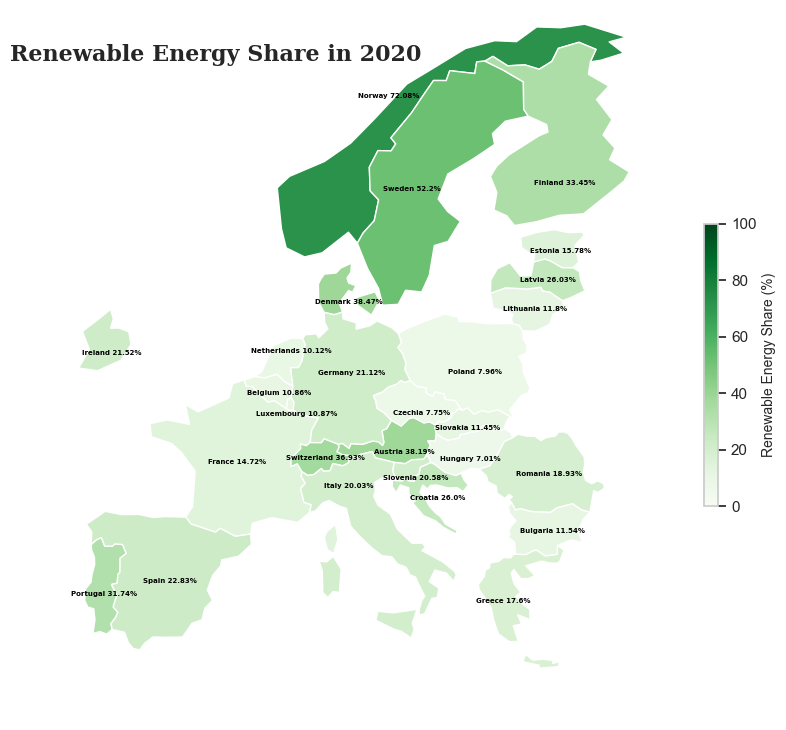

In [42]:
show_renewable_energy_for_year(year, merged_data)

**How much green house emissions are emitted per capita from 1990?**

Here is an example for 2020 year.

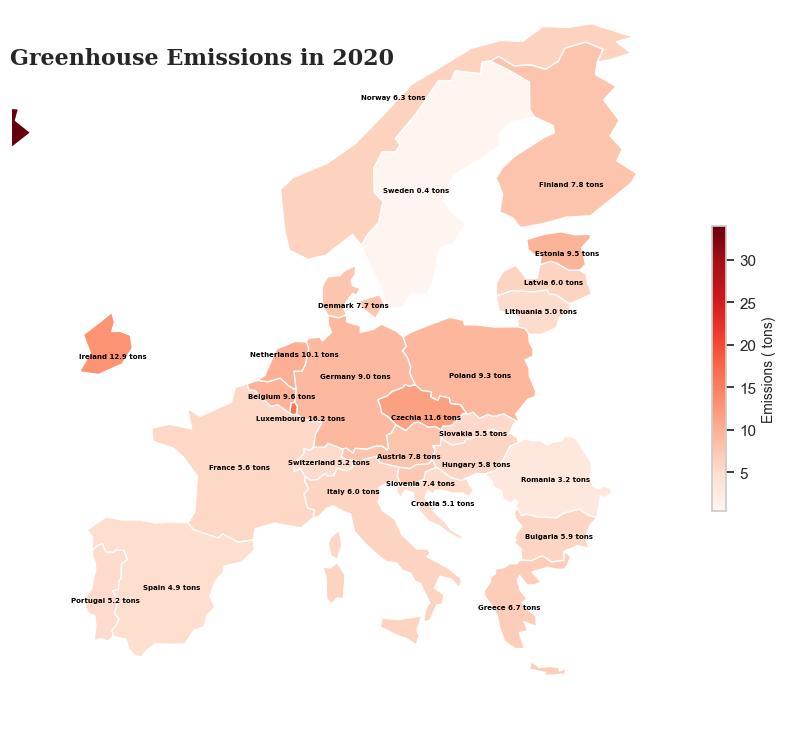

In [43]:
show_greenhouse_emissions_for_year(year, merged_data)

Here we answer the question of *What is the impact of the percentage of total energy consumption on the greenhouse gas emissions in Norway, Sweden, France and other European countries?*

This is the method that we will use to look at different countries:

In [44]:
def show_impact_scatterplot(merged_data, country):
    if country == 'All':
        x = merged_data["OBS_VALUE"]
        y = merged_data["Renewables (% equivalent primary energy)"]
    else:
        x = merged_data[merged_data['geo'] == country]["OBS_VALUE"]
        y = merged_data[merged_data['geo'] == country]["Renewables (% equivalent primary energy)"]

    # Fit LOWESS (locally weighted scatterplot smoothing)
    lowess = sm.nonparametric.lowess(y, x, frac=0.3)  # frac determines the smoothing; adjust if needed

    # Extract LOWESS x and y
    lowess_x = lowess[:, 0]
    lowess_y = lowess[:, 1]

    # Calculate confidence intervals (simplified bootstrap method)
    n_boot = 1000
    boot_lowess_y = np.zeros((n_boot, len(lowess_x)))

    for i in range(n_boot):
        sample_idx = np.random.choice(len(x), len(x), replace=True)
        boot_sample_x = x.iloc[sample_idx]
        boot_sample_y = y.iloc[sample_idx]
        boot_lowess = sm.nonparametric.lowess(boot_sample_y, boot_sample_x, frac=0.3)
        boot_lowess_y[i, :] = np.interp(lowess_x, boot_lowess[:, 0], boot_lowess[:, 1])

    # Compute the 2.5th and 97.5th percentiles for confidence intervals
    ci_lower = np.percentile(boot_lowess_y, 5, axis=0)
    ci_upper = np.percentile(boot_lowess_y, 95, axis=0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, label="Data Points")
    plt.plot(lowess_x, lowess_y, color="red", label="LOWESS Fit")
    plt.fill_between(lowess_x, ci_lower, ci_upper, color="red", alpha=0.2, label="95% Confidence Interval")

    # Add labels and title
    plt.title(f"Scatter Plot: Renewable Energy vs Emissions: {country}", fontsize=14)
    plt.xlabel("Emissions (tons per capita)", fontsize=12)
    plt.ylabel("Renewable Energy (% of Total Energy)", fontsize=12)
    plt.legend()

    # Show the plot
    plt.show()

Norway:

C:\Users\romad\AppData\Roaming\Python\Python312\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


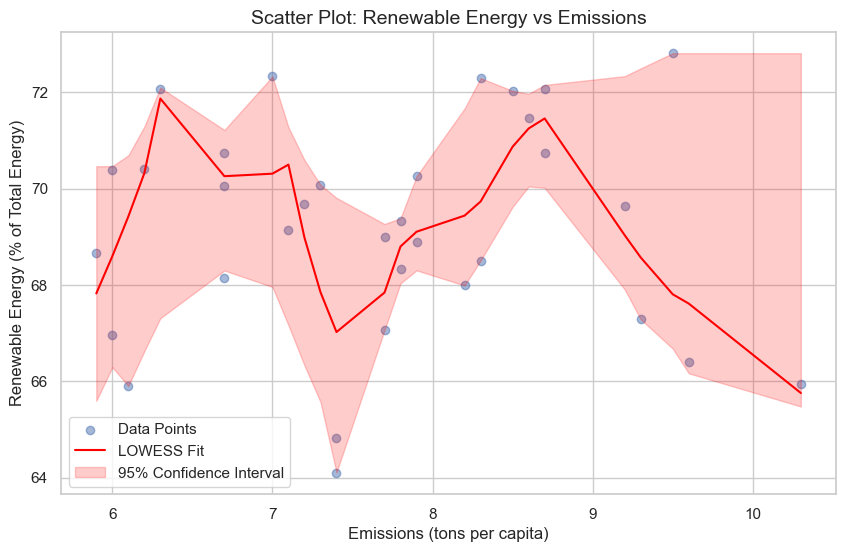

In [45]:
show_impact_scatterplot(merged_data, 'Norway')

France:

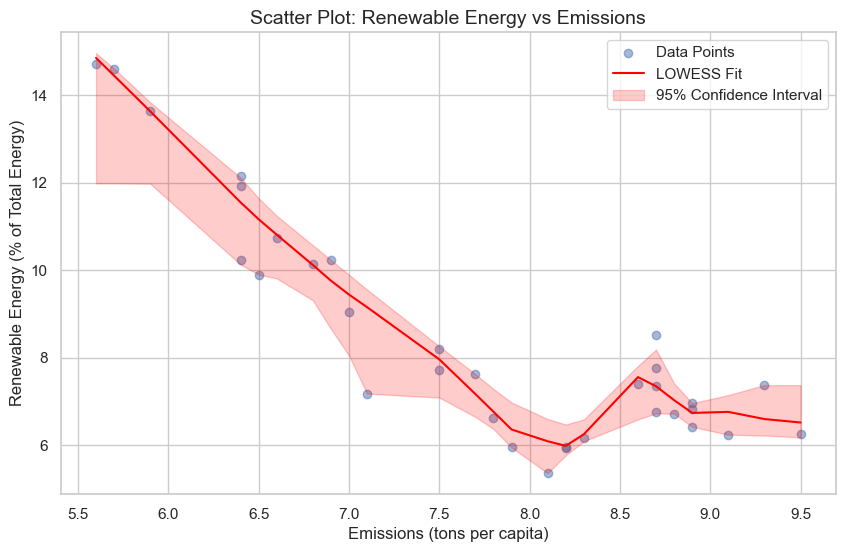

In [46]:
show_impact_scatterplot(merged_data, 'France')

All Countries:

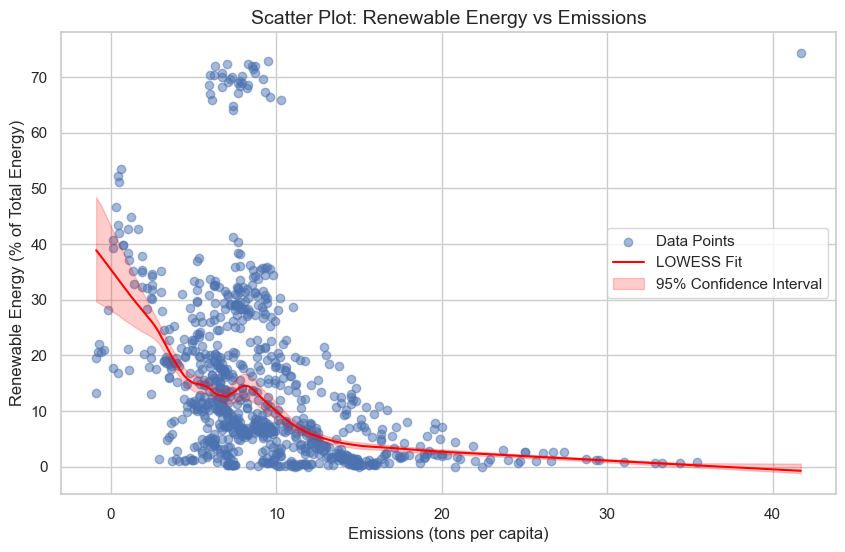

In [47]:
show_impact_scatterplot(merged_data, 'All')